In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
# Read in data source, display first 5 rows

df = pd.read_csv('Paitients_Files_Train - Paitients_Files_Train.csv')
df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6.0,148.00 mu U,72.00 mm Hg,35.00 mm,0.00 ml,33.60 BMI,0.63 mu U,50,0,Positive
1,ICU200011,1.0,85.00 mu U,66.00 mm Hg,29.00 mm,0.00 ml,26.60 BMI,0.35 mu U,31,0,Negative
2,ICU200012,8.0,183.00 mu U,64.00 mm Hg,0.00 mm,0.00 ml,23.30 BMI,0.67 mu U,32,1,Positive
3,ICU200013,1.0,89.00 mu U,66.00 mm Hg,23.00 mm,94.00 ml,28.10 BMI,0.17 mu U,21,1,Negative
4,ICU200014,0.0,137.00 mu U,40.00 mm Hg,35.00 mm,168.00 ml,43.10 BMI,2.29 mu U,33,1,Positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    float64
 2   PL         599 non-null    object 
 3   PR         599 non-null    object 
 4   SK         599 non-null    object 
 5   TS         599 non-null    object 
 6   M11        599 non-null    object 
 7   BD2        599 non-null    object 
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(1), int64(2), object(8)
memory usage: 51.6+ KB


In [7]:
# Clean up data values by removing labels from vital columns
# and encoding Sepssis column

le = LabelEncoder()
df['ID'] = df['ID'].str.replace(r'^ICU', '', regex=True)
df['PL'] = df['PL'].str.replace(r'\smu U', '', regex=True)
df['PR'] = df['PR'].str.replace(r'\smm Hg', '', regex=True)
df['SK'] = df['SK'].str.replace(r'\smm', '', regex=True)
df['TS'] = df['TS'].str.replace(r'\sml', '', regex=True)
df['M11'] = df['M11'].str.replace(r'\sBMI', '', regex=True)
df['BD2'] = df['BD2'].str.replace(r'\smu U', '', regex=True)
df['Sepssis_encoded'] = le.fit_transform(df['Sepssis'])

# Assign numerical values from strings in temp dataframe
df_temp = df.drop(columns=['Sepssis', 'ID', 'PRG'], axis=1)
df_temp = df_temp.apply(lambda x: pd.to_numeric(x), axis=0)


In [9]:
# Check for NaN values

df_temp.isna().any().any()

np.False_

In [11]:
# Check for null values

df_temp.isnull().values.any()

np.False_

In [13]:
# What are the new data types

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PL               599 non-null    float64
 1   PR               599 non-null    float64
 2   SK               599 non-null    float64
 3   TS               599 non-null    float64
 4   M11              599 non-null    float64
 5   BD2              599 non-null    float64
 6   Age              599 non-null    int64  
 7   Insurance        599 non-null    int64  
 8   Sepssis_encoded  599 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 42.2 KB


In [15]:
# Create training and testing data set from df_temp and df dataframe
# Grab column names

column_names = df_temp.columns

# Scale the feeatures

scaler = MinMaxScaler()
scaler.fit(df_temp)
df_temp = pd.DataFrame(scaler.fit_transform(df_temp), columns=column_names)
X = df_temp.drop(columns=['Sepssis_encoded'], axis=1)

# Sepssis is a binary value, no scaling needed
y = df['Sepssis_encoded']

# Create training and testing data
X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# define the models to do a GridSearch over

clfs = [LinearRegression(),
        KNeighborsRegressor(), 
        DecisionTreeRegressor(), 
        Ridge(), 
        SVR()]

# define the parameters to search over
# this took a few guess and check runs 
# to settle on 

param_grids = {'linear': {},
               'knn': {'n_neighbors': [23, 24, 25]},
               'tree': {'max_depth': [1, 2, 3]},
               'ridge': {'alpha': [0.1, 1, 2, 3, 4]},
               'svr':  {'kernel' : ('linear', 'rbf', 'sigmoid'),
                        'C' : [0.1, 0.5, 1.0, 1.5, 2.0],
                        'degree' : [1, 3, 5, 7],
                        'coef0' : [0.0001, 0.001, 0.01],
                        'gamma' : ('auto','scale')}
              }

# store test/predicted mse errors in a dictionary

results_mseerror_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store best_score_ in a dictionary

results_bestscore_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store training accuracy in a dictionary

training_results_accuracy_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store test accuracy in a dictionary

test_results_accuracy_grid = {'linear': [],
                      'knn': [],
                      'decision': [],
                      'ridge': [],
                      'svr': []
                     }

# store best parameters from GridSearch in a dictionary

best_params_grid = {'linear': [],
                    'knn': [],
                    'decision': [],
                    'ridge': [],
                    'svr': []
                   }

k = 0

# do a GridSearch using the different models and parameter grids

for model, name in zip(clfs, ['linear', 'knn', 'tree', 'ridge', 'svr']):
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_Train, y_train)
    best_pipeline = grid_search.best_estimator_
    best_score = grid_search.best_score_
    y_pred_train = best_pipeline.predict(X_Train)
    y_pred_train_class = np.where(y_pred_train >= 0.5, 1,0)
    y_pred = best_pipeline.predict(X_Test)
    y_pred_class = np.where(y_pred >= 0.5, 1,0)
    results_mseerror_grid[list(results_mseerror_grid.keys())[k]] = mean_squared_error(y_test, y_pred_class)
    results_bestscore_grid[list(results_bestscore_grid.keys())[k]] = best_score
    training_results_accuracy_grid[list(training_results_accuracy_grid.keys())[k]] = accuracy_score(y_train, y_pred_train_class)
    test_results_accuracy_grid[list(test_results_accuracy_grid.keys())[k]] = accuracy_score(y_test, y_pred_class)
    best_params_grid[list(best_params_grid.keys())[k]] = grid_search.best_params_
    k += 1


In [19]:
results_mseerror_grid

{'linear': np.float64(0.2388888888888889),
 'knn': np.float64(0.3333333333333333),
 'decision': np.float64(0.28888888888888886),
 'ridge': np.float64(0.2611111111111111),
 'svr': np.float64(0.25)}

In [21]:
training_results_accuracy_grid

{'linear': 0.7780429594272077,
 'knn': 0.766109785202864,
 'decision': 0.7684964200477327,
 'ridge': 0.7756563245823389,
 'svr': 0.7947494033412887}

In [23]:
test_results_accuracy_grid

{'linear': 0.7611111111111111,
 'knn': 0.6666666666666666,
 'decision': 0.7111111111111111,
 'ridge': 0.7388888888888889,
 'svr': 0.75}

In [25]:
results_bestscore_grid

{'linear': np.float64(-0.16119210778470738),
 'knn': np.float64(-0.16876902451074138),
 'decision': np.float64(-0.163637728632874),
 'ridge': np.float64(-0.16068009000001543),
 'svr': np.float64(-0.16329726451730922)}

In [27]:
best_params_grid

{'linear': {},
 'knn': {'n_neighbors': 24},
 'decision': {'max_depth': 2},
 'ridge': {'alpha': 1},
 'svr': {'C': 0.5,
  'coef0': 0.0001,
  'degree': 1,
  'gamma': 'scale',
  'kernel': 'rbf'}}

In [29]:
# Coefficients from Ridge regression
# had the lowest best_score_  
# using best_params from run

ridge_reg = Ridge(alpha = 1)
ridge_reg.fit(X_Train, y_train)
coefficients_ridge = ridge_reg.coef_
coefficients_ridge_df = pd.DataFrame({'feature': X_Train.columns, 'coefficient': coefficients_ridge})
coefficients_ridge_df = coefficients_ridge_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Ridge Regression:")
print(coefficients_ridge_df)


Coefficients from Ridge Regression:
     feature  coefficient
0         PL     1.018130
4        M11     0.990655
5        BD2     0.367955
6        Age     0.204976
7  Insurance     0.072684
3         TS     0.068662
2         SK    -0.032800
1         PR    -0.180991


In [31]:
# Coefficients from Linear regression

linear_reg = LinearRegression()
linear_reg.fit(X_Train, y_train)
coefficients_linear = linear_reg.coef_
coefficients_linear_df = pd.DataFrame({'feature': X_Train.columns, 'coefficient': coefficients_linear})
coefficients_linear_df = coefficients_linear_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Linear Regression:")
print(coefficients_linear_df)


Coefficients from Linear Regression:
     feature  coefficient
4        M11     1.209178
0         PL     1.098425
5        BD2     0.382251
6        Age     0.200655
7  Insurance     0.068691
3         TS     0.039529
2         SK    -0.075161
1         PR    -0.229274


In [33]:
# Feature importance using permutation for KNN
# using values from best run

best_knn = KNeighborsRegressor(n_neighbors = 24) 
best_knn.fit(X_Train, y_train)
result_knn = permutation_importance(best_knn, X_Test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_Test.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN:")
print(perm_importances_knn)


Permutation Importance from KNN:
     feature  importance
0         PL    0.180248
6        Age    0.060548
4        M11    0.049600
7  Insurance    0.014462
2         SK    0.010151
1         PR    0.010097
5        BD2    0.003771
3         TS    0.000274


In [35]:
# Feature importance using permutation for SVR
# using values from best run

best_svr = SVR(C = 0.5, coef0 = 0.0001, degree = 1, gamma = 'auto', kernel = 'linear')
best_svr.fit(X_Train, y_train)
result_svr = permutation_importance(best_svr, X_Test, y_test, random_state=42)
perm_importances_svr = pd.DataFrame({'feature': X_Test.columns, 'importance': result_svr.importances_mean})
perm_importances_svr = perm_importances_svr.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVR:")
print(perm_importances_svr)


Permutation Importance from SVR:
     feature  importance
0         PL    0.303453
4        M11    0.121438
1         PR    0.025345
6        Age    0.019182
5        BD2    0.005347
2         SK    0.004170
7  Insurance   -0.000478
3         TS   -0.019115


In [37]:
# Feature importance from Decision Tree
# using values from best run

tree_reg = DecisionTreeRegressor(max_depth = 2)
tree_reg.fit(X_Train, y_train)
importances_tree = tree_reg.feature_importances_
feature_importance_tree_df = pd.DataFrame({'feature': X_Train.columns, 'importance': importances_tree})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)


Feature Importance from Decision Tree:
     feature  importance
0         PL    0.894542
4        M11    0.105458
1         PR    0.000000
2         SK    0.000000
3         TS    0.000000
5        BD2    0.000000
6        Age    0.000000
7  Insurance    0.000000


In [63]:
# set random seed

tf.random.set_seed(42)

# Test run 1 with neural network
# Create 1 hidden node in the neural network, output should be 
# binary/sigmoid as trying to predict sepsis binary value

model = Sequential([
    Dense(100, activation = 'relu'),
    Dense(5, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# set what we are optimizing for (binary values), and fit model
model.compile(loss = 'bce', optimizer = 'rmsprop', metrics = ['accuracy'])
history = model.fit(X_Train, y_train, epochs = 20, batch_size = 10, verbose = 0)

# how does the model accuracy look on our training data
# the result is in the ballpark of the linear model from Assignment 20
# but need to check for overfitting
print(history.history['accuracy'][-1])

0.7732697129249573


In [65]:
# Test run 2 with neural network
# Simplify the neural net by removing hidden nodes,
# set what we are optimizing for binary values
# using sigmoid and fit model

model = Sequential([
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model.compile(loss = 'bce', optimizer = 'rmsprop', metrics = ['accuracy'])

history = model.fit(X_Train, y_train, epochs = 20, batch_size = 10, verbose = 0)

# how does the model accuracy look on our training data
# the result is also in the ballpark of the linear model from 
# Assignment 20 (still worse than the linear model though)
# and about the same performance as the more complex neural net

print(history.history['accuracy'][-1])

0.7541766166687012


In [67]:
# let's try a more complex network design with different
# activation functions at each node, 1 hidden node, with
# 1000 nodes at input using tanh, 10000 in hidden node
# using relue, and a singular output node using sigmoid 
# for binary output

model_mixed_activ = Sequential([
    Dense(1000, activation = 'tanh'),
    Dense(10000, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model_mixed_activ.compile(loss = 'bce', optimizer = 'rmsprop', metrics = ['accuracy'])

# use test set for data validation and then display 
# training and testing accuracy
history_mixed_activ = model_mixed_activ.fit(X_Train, y_train, validation_data = (X_Test, y_test), verbose = 1,epochs = 20, batch_size = 10)

# the results indicate overfitting despite initial result on
# training set that indicates the model performs better (80.4% 
# accuracy) compares to the linear one from Assignment 20:(

print("Mixed activation training accuracy", history_mixed_activ.history['accuracy'][-1])
print("Mixed activation testing accuracy", history_mixed_activ.history['val_accuracy'][-1])

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5846 - loss: 0.6987 - val_accuracy: 0.5444 - val_loss: 0.6792
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6501 - loss: 0.6051 - val_accuracy: 0.5944 - val_loss: 0.6825
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6903 - loss: 0.5729 - val_accuracy: 0.6111 - val_loss: 0.6904
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7096 - loss: 0.5529 - val_accuracy: 0.6111 - val_loss: 0.6913
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7174 - loss: 0.5370 - val_accuracy: 0.6278 - val_loss: 0.6912
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7222 - loss: 0.5248 - val_accuracy: 0.6500 - val_loss: 0.6884
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7372 - loss: 0.5145 - val_accuracy: 0.6611 - val_loss: 0.6865
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7532 - loss: 0.5068 - val_accuracy: 0.6722 - v

In [71]:
print("Mixed activation mse", model_mixed_activ.evaluate(X_Test, y_test, verbose=0)[0])

Mixed activation mse 0.6907750368118286


In [73]:
def score_model(model, X, y):
    _, accuracy = model.evaluate(X, y, verbose=0)
    return accuracy

result_mixednn = permutation_importance(model_mixed_activ, X_Test, y_test, scoring=score_model, n_repeats=10, random_state=42)
perm_importances_mixednn = pd.DataFrame({'feature': X_Test.columns, 'importance': result_mixednn.importances_mean})
perm_importances_mixednn = perm_importances_mixednn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from Tanh/Relu/Sigmoid NN:")
print(perm_importances_mixednn)


Permutation Importance from Tanh/Relu/Sigmoid NN:
     feature  importance
0         PL    0.149444
4        M11    0.056111
6        Age    0.021667
3         TS    0.016111
7  Insurance    0.013889
1         PR    0.003333
5        BD2   -0.001111
2         SK   -0.002778


In [75]:
# let's try another variant but only using relu as the
# activation function at the input node, and then a
# using sigmoid at the output node due to binary prediction

model_nonmixed = Sequential([
    Dense(100, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model_nonmixed.compile(loss = 'bce', optimizer = 'rmsprop', metrics = ['accuracy'])

history_simplenn = model_nonmixed.fit(X_Train, y_train, validation_data = (X_Test, y_test), verbose = 1,epochs = 20, batch_size = 5)

# the results also indicate overfitting compared
# to the linear one from Assignment 20:(

print("Nonmixed activation training accuracy", history_simplenn.history['accuracy'][-1])
print("Nonmixed activation testing accuracy", history_simplenn.history['val_accuracy'][-1])

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6654 - loss: 0.6592 - val_accuracy: 0.6333 - val_loss: 0.6567
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6749 - loss: 0.6342 - val_accuracy: 0.6333 - val_loss: 0.6498
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.6749 - loss: 0.6242 - val_accuracy: 0.6333 - val_loss: 0.6429
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.6761 - loss: 0.6149 - val_accuracy: 0.6222 - val_loss: 0.6363
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.6762 - loss: 0.6060 - val_accuracy: 0.6222 - val_loss: 0.6296
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6840 - loss: 0.5972 - val_accuracy: 0.6333 - val_loss: 0.6231
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6883 - loss: 0.5883 - val_accuracy: 0.6389 - val_loss: 0.6164
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7142 - loss: 0.5799 - val_accuracy: 0.65

In [79]:
print("Nonmixed activation mse", model_nonmixed.evaluate(X_Test, y_test, verbose=0)[0])

Nonmixed activation mse 0.5629549622535706


In [81]:
result_nonmixed = permutation_importance(model_nonmixed, X_Test, y_test, scoring=score_model, n_repeats=10, random_state=42)
perm_importances_nonmixed = pd.DataFrame({'feature': X_Test.columns, 'importance': result_nonmixed.importances_mean})
perm_importances_nonmixed = perm_importances_nonmixed.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from Relu/Sigmoid NN:")
print(perm_importances_nonmixed)


Permutation Importance from Relu/Sigmoid NN:
     feature  importance
0         PL    0.096667
6        Age    0.044444
1         PR    0.029444
4        M11    0.025556
5        BD2    0.018889
2         SK    0.007778
7  Insurance   -0.005556
3         TS   -0.007778


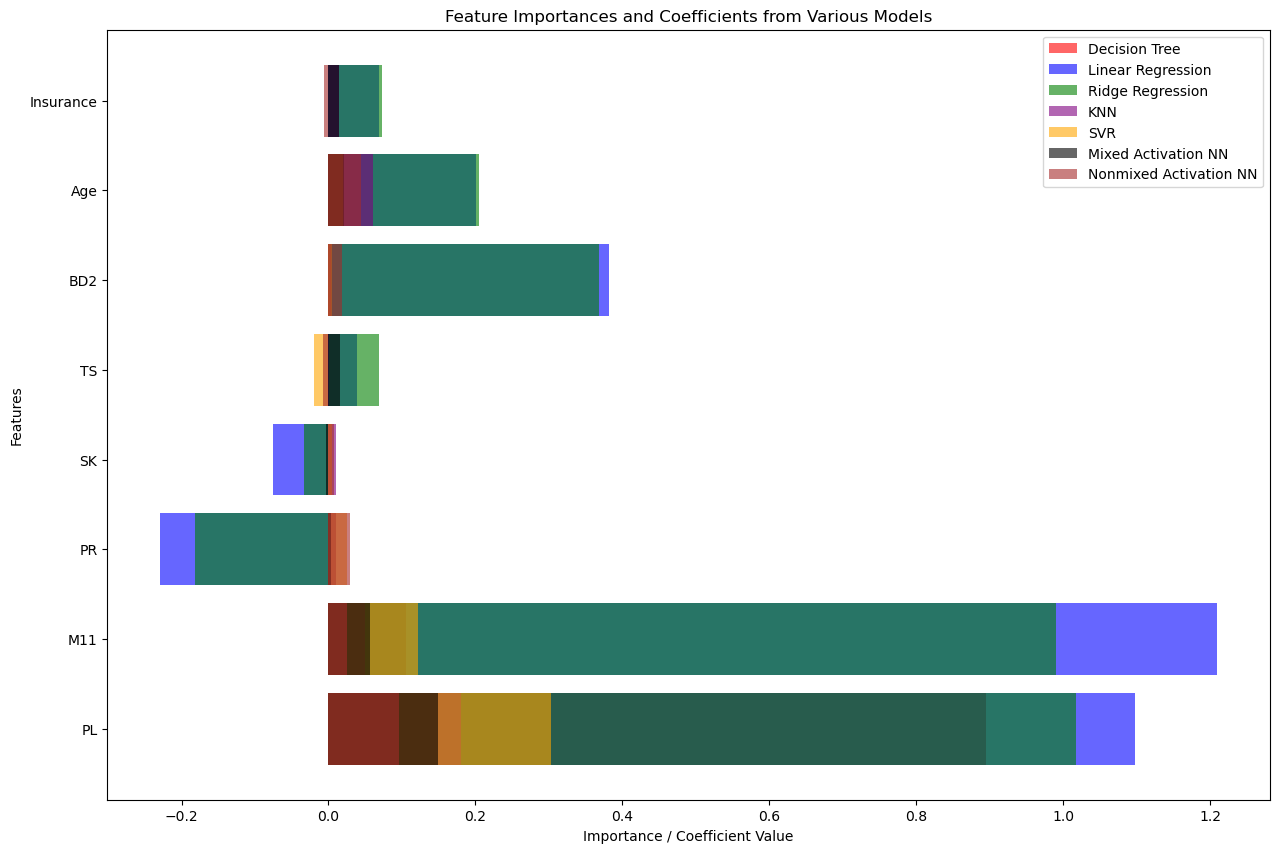

In [82]:
# Plotting the feature importances and coefficients
plt.figure(figsize=(15, 10))

# Plot Decision Tree feature importance
plt.barh(feature_importance_tree_df['feature'], feature_importance_tree_df['importance'], color='red', alpha=0.6, label='Decision Tree')

# Plot Linear Regression coefficients
plt.barh(coefficients_linear_df['feature'], coefficients_linear_df['coefficient'], color='blue', alpha=0.6, label='Linear Regression')

# Plot Ridge Regression coefficients
plt.barh(coefficients_ridge_df['feature'], coefficients_ridge_df['coefficient'], color='green', alpha=0.6, label='Ridge Regression')

# Plot KNN permutation importance
plt.barh(perm_importances_knn['feature'], perm_importances_knn['importance'], color='purple', alpha=0.6, label='KNN')

# Plot SVR permutation importance
plt.barh(perm_importances_svr['feature'], perm_importances_svr['importance'], color='orange', alpha=0.6, label='SVR')

# Plot Mixed activation permutation importance
plt.barh(perm_importances_mixednn['feature'], perm_importances_mixednn['importance'], color='black', alpha=0.6, label='Mixed Activation NN')

# Plot Nonmixed activation permutation importance
plt.barh(perm_importances_nonmixed['feature'], perm_importances_nonmixed['importance'], color='brown', alpha=0.6, label='Nonmixed Activation NN')

plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Various Models')
plt.legend()
plt.show()

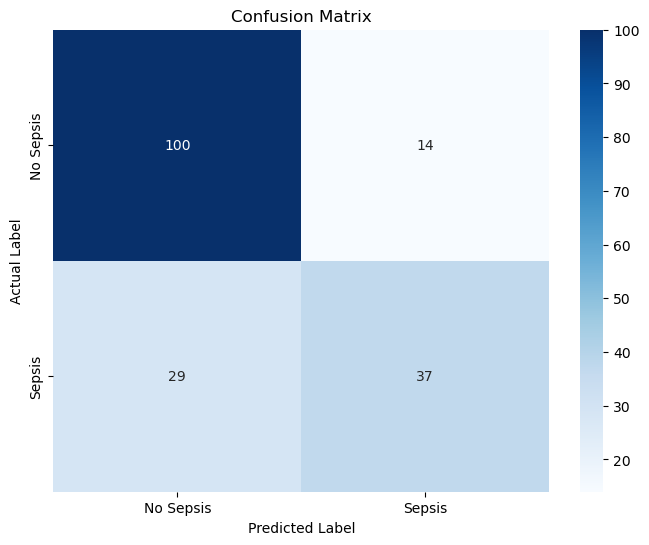

[[100  14]
 [ 29  37]]


In [85]:
# Sample actual and predicted labels
y_test
predicted = linear_reg.predict(X_Test)
predicted_class = np.where(predicted >= 0.5, 1,0)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)

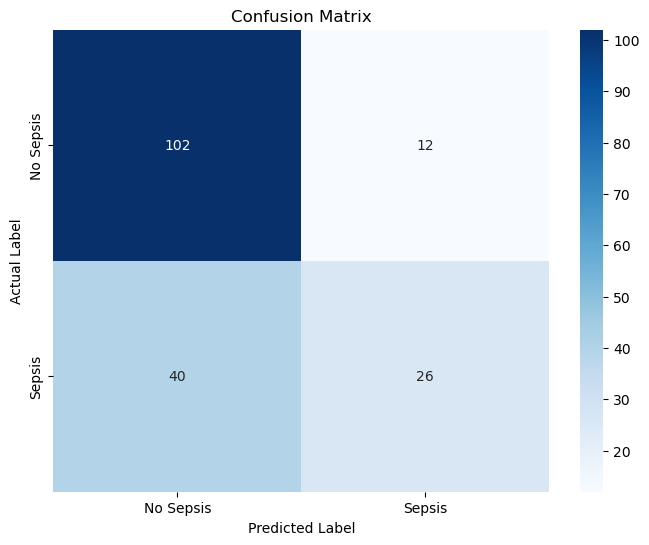

[[102  12]
 [ 40  26]]


In [87]:
# Sample actual and predicted labels
y_test
predicted = best_svr.predict(X_Test)
predicted_class = np.where(predicted >= 0.5, 1,0)

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)